In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,20855,None,None,88626.429401
2020-06-13,20856,None,None,81909.580639
2020-06-14,20857,None,None,75723.434989
2020-06-15,20858,None,None,70069.857284
2020-06-16,20859,None,None,65123.314919
...,...,...,...,...
2020-12-27,21053,None,None,513971.224867
2020-12-28,21054,None,None,539362.988133
2020-12-29,21055,None,None,565801.454726


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2020-12-31_2020-12-31-16-06.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2020-12-30_2020-12-30-20-05.pickle


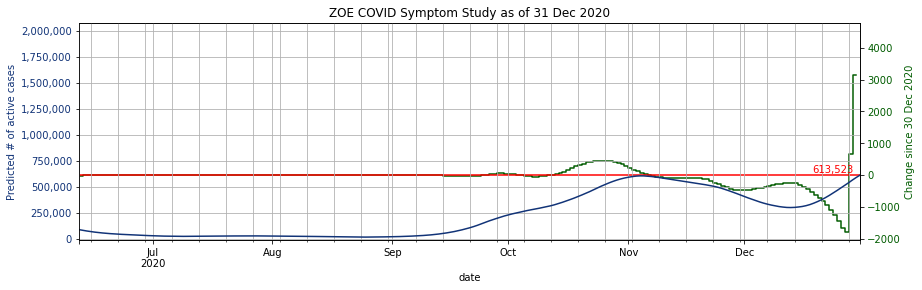

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

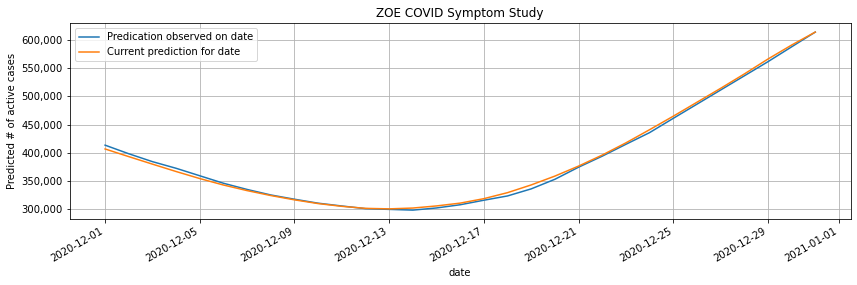

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2020-12-31_2020-12-31-16-07.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
342,Bridgend,W06000013,7.745571
384,Torfaen,W06000020,5.833526
333,Flintshire,W06000005,3.688524
329,Denbighshire,W06000004,3.376269
312,Bexley,E09000004,3.337821
382,Caerphilly,W06000018,3.011985
381,Rhondda Cynon Taf,W06000016,2.870721
343,Vale of Glamorgan,W06000014,2.799903
378,Sutton,E09000029,2.605581
338,Croydon,E09000008,2.541130
